# <center> Исследование данных HR-агентства

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Описание исходных данных:

- **work_year** - Год, в котором была выплачена зарплата.
- **experience_level** - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
- **employment_type** - Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
- **job_title** - Роль, в которой соискатель работал в течение года.
- **salary** - Общая выплаченная валовая сумма заработной платы.
- **salary_currency** - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- **salary_in_usd** - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через [foorilla.com](fxdata.foorilla.com).
- **employee_residence** - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- **remote_ratio** - Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
- **company_location** - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- **company_size** - Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

## Загрузка данных

In [271]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [272]:
# Загрузка и отображение данных
df_ds_salaries = pd.read_csv('./data/ds_salaries.csv', index_col=0)
df_ds_salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Описательный анализ данных

In [273]:
df_ds_salaries.info()
print(f'Количество пропущенных значений в исходных данных: {df_ds_salaries.isna().sum().sum()}')

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB
Количество пропущенных значений в исходных данных: 0


Исходные данные содержат 607 записей, пропущенных значений нет.

In [274]:
print(f'Количество дубликатов: {df_ds_salaries.duplicated().sum()}')

# Удаление дубликатов
df_ds_salaries_cleared = df_ds_salaries.drop_duplicates()
print(f'Размерность таблицы после удаления дубликатов: {df_ds_salaries_cleared.shape}')

Количество дубликатов: 42
Размерность таблицы после удаления дубликатов: (565, 11)


После очистки исходных данных от дубликатов количество строк в датасете сократилось до 565.

### Предварительная подготовка

Определение типов признаков:  
- **work_year** (Год выплаты зарплаты) - числовой дискретный;
- **experience_level** (Опыт работы на должности в течение года) - порядковый категориальный;
- **employment_type** (Тип трудоустройства) - номинальный категориальный;
- **job_title** - (Роль, в которой соискатель работал в течение года) - номинальный категориальный;
- ~~*salary*~~ (Общая выплаченная валовая сумма заработной платы) - подлежит удалению;
- ~~*salary_currency*~~ (Валюта выплачиваемой заработной платы) - подлежит удалению;
- **salary_in_usd** (Зарплата в долларах США) - числовой непрерывный;
- **employee_residence** (Основная страна проживания сотрудника) - номинальный категориальный;
- **remote_ratio** (Общий объём работы, выполняемой удалённо) - порядковый категориальный (представлен в числовом виде);
- **company_location** (Страна главного офиса работодателя или филиала по контракту) - номинальный категориальный;
- **company_size** (Среднее количество людей, работавших в компании в течение года) - порядковый категориальный.

Признаки ~~*salary*~~ и ~~*salary_currency*~~ подлежат удалению, так как в датасете присутствует признак **salary_in_usd**, который уже объединяет в себе данные из них в единой валюте (USD).

In [275]:
# Удаление неинформативных признаков
df_ds_salaries_cleared = df_ds_salaries_cleared.drop(columns=['salary', 'salary_currency'],
                                                     axis=1)
# Перевод категориальных признаков в 'category'
df_ds_salaries_cleared['remote_ratio'] = df_ds_salaries_cleared['remote_ratio'].astype('category')
for col in df_ds_salaries_cleared.columns:
    if df_ds_salaries_cleared[col].dtype == 'object':
        df_ds_salaries_cleared[col] = df_ds_salaries_cleared[col].astype('category')

df_ds_salaries_cleared.info()
df_ds_salaries_cleared.head()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    int64   
 1   experience_level    565 non-null    category
 2   employment_type     565 non-null    category
 3   job_title           565 non-null    category
 4   salary_in_usd       565 non-null    int64   
 5   employee_residence  565 non-null    category
 6   remote_ratio        565 non-null    category
 7   company_location    565 non-null    category
 8   company_size        565 non-null    category
dtypes: category(7), int64(2)
memory usage: 25.2 KB


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


### Основные статистические характеристики признаков

In [276]:
df_ds_salaries_cleared.describe().round(2)

,work_year,salary_in_usd
count,565.00,565.00
mean,2021.36,110610.34
std,0.70,72280.70
min,2020.00,2859.00
25%,2021.00,60757.00
50%,2021.00,100000.00
75%,2022.00,150000.00
max,2022.00,600000.00


In [277]:
df_ds_salaries_cleared.describe(include='category')

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,565,565,565,565,565,565,565
unique,4,4,50,57,3,50,3
top,SE,FT,Data Scientist,US,100,US,M
freq,243,546,130,295,346,318,290


## Разведывательный анализ данных

Так как ключевые вопросы HR-агентства связаны с конкретным упоминанием категории специалистов Data Scientist и Data Engineer, дальнейшее рассмотрение датасета производится с фильтрацией по данным значениям в признаке job_title.

In [278]:
# Фильтрация данных
mask_ds = df_ds_salaries_cleared['job_title'] == 'Data Scientist'
mask_de = df_ds_salaries_cleared['job_title'] == 'Data Engineer'
df_ds_salaries_cleared = df_ds_salaries_cleared[mask_ds | mask_de]
# Удаление неиспользуемых категорий в отфильтрованных данных
for col in df_ds_salaries_cleared.columns:
    if df_ds_salaries_cleared[col].dtype == 'category':
        df_ds_salaries_cleared[col] = df_ds_salaries_cleared[col].cat.remove_unused_categories()
# Сброс индексации записей
df_ds_salaries_cleared = df_ds_salaries_cleared.reset_index(drop=True)
# Реиндексация фильтров
mask_ds = df_ds_salaries_cleared['job_title'] == 'Data Scientist'
mask_de = df_ds_salaries_cleared['job_title'] == 'Data Engineer'

df_ds_salaries_cleared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           251 non-null    int64   
 1   experience_level    251 non-null    category
 2   employment_type     251 non-null    category
 3   job_title           251 non-null    category
 4   salary_in_usd       251 non-null    int64   
 5   employee_residence  251 non-null    category
 6   remote_ratio        251 non-null    category
 7   company_location    251 non-null    category
 8   company_size        251 non-null    category
dtypes: category(7), int64(2)
memory usage: 6.5 KB


После фильтрации исходных данных количество строк в датасете сократилось до 251.

### Визуальный анализ данных

In [279]:
# Расшифровка признаков для графиков
dict_col_name_rus = {'work_year': 'Год выплаты зарплаты',
                     'experience_level': 'Опыт работы на должности в течение года',
                     'employment_type': 'Тип трудоустройства',
                     'job_title': 'Роль, в которой соискатель работал в течение года',
                     'salary_in_usd': 'Зарплата в долларах США',
                     'employee_residence': 'Основная страна проживания сотрудника',
                     'remote_ratio': 'Общий объём работы, выполняемой удалённо',
                     'company_location': 'Страна главного офиса работодателя или филиала по контракту',
                     'company_size': 'Среднее количество людей, работавших в компании в течение года'}

#### Числовые признаки

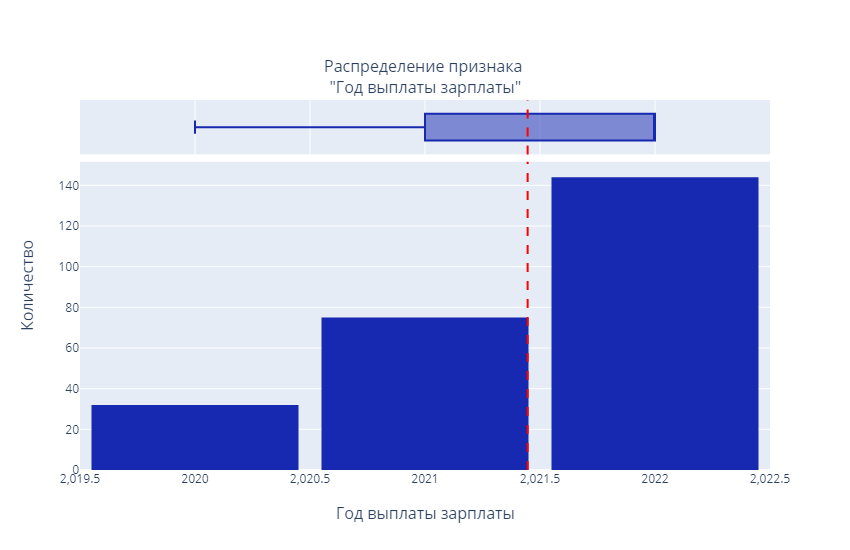

Статистические данные признака:


count     251.00
mean     2021.45
std         0.71
min      2020.00
25%      2021.00
50%      2022.00
75%      2022.00
max      2022.00
Name: work_year, dtype: float64

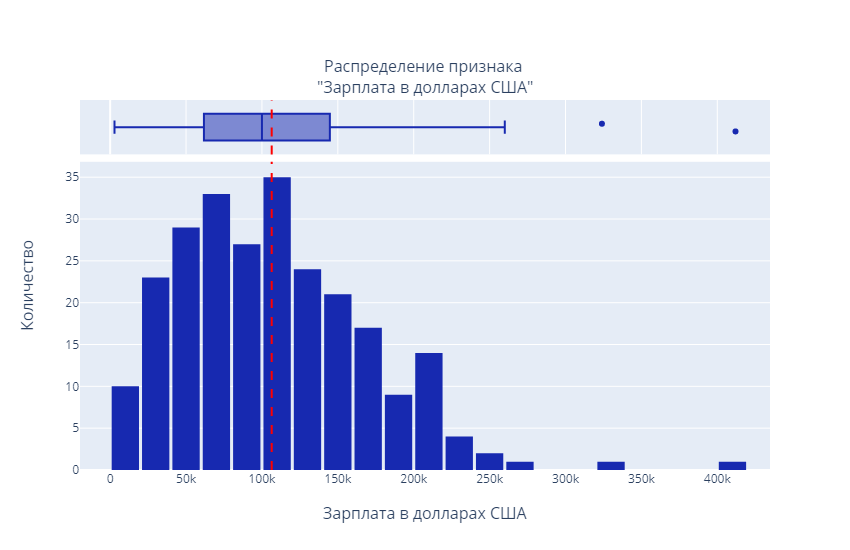

Статистические данные признака:


count       251.00
mean     106428.21
std       61219.17
min        2859.00
25%       62096.50
50%      100000.00
75%      144500.00
max      412000.00
Name: salary_in_usd, dtype: float64

In [280]:
# Построение гистограммы распределения каждого числового признака
for col in df_ds_salaries_cleared.columns:
    if pd.api.types.is_numeric_dtype(df_ds_salaries_cleared[col].dtype):
        # Инициализация полотна на два графика с общей осью X
        fig_col = make_subplots(rows=2, cols=1,
                                shared_xaxes=True, # Общая ось Х
                                x_title=dict_col_name_rus[col],
                                y_title='Количество',
                                row_heights=[0.15, 0.85], # Относительная высота полотен
                                subplot_titles=(f"Распределение признака <br>\"{dict_col_name_rus[col]}\"", ""),
                                vertical_spacing=0.02) # Высота разделителя
        # Построение коробчатой диаграммы
        fig_col.add_trace(go.Box(x=df_ds_salaries_cleared[col],
                                 marker_color = '#1729B0', # Цвет маркера
                                 jitter=0.5, # Разнос точек выбросов по вертикали
                                 name='',
                                 showlegend=False),
                          row=1, col=1)
        # Построение гистограммы
        fig_col.add_trace(go.Histogram(x=df_ds_salaries_cleared[col],
                                       marker_color = '#1729B0', # Цвет маркера
                                       name=dict_col_name_rus[col], # Название набора данных
                                       showlegend=False),
                          row=2, col=1)
        # Построение линии среднего значения
        fig_col.add_vline(x=df_ds_salaries_cleared[col].mean(),
                          line=dict(color="Red", dash='dash')) # Стиль линии
        # Размер полотна
        fig_col.update_layout(autosize = False, width = 850, height = 550,
                              bargap=0.1) # Расстояние между столбцами гистограммы
        fig_col.show('png')
        
        print('Статистические данные признака:')
        display(df_ds_salaries_cleared[col].describe().round(2))

Признак **'Год выплаты зарплаты'**:  
Числовой признак является дискретным, количество значений равно трем, а промежутки между ними равны, что позволяет рассматривать его как порядковый категориальный. Количество записей возрастает с увеличением года.  
При рассмотрении года выплаты зарплаты следует отметить достаточно малое количество данных за 2020 год.

Признак **'Зарплата в долларах США'**:  
Является целевым признаком в рассматриваемых вопросах. Из формы гистограммы и неравенства среднего значения зарплаты и ее медианы следует, что распределение значений отлично от нормального, а именно является правосторонним скошенным, что означает, что большая часть данных сосредоточена в нижнем диапазоне, а небольшая часть специалистов является высокооплачиваемыми. Форма коробчатой диаграммы свидетельствует о наличии выбросов, где зарплата значительно превышает медиану. Эти данные могут быть связаны с высокооплачиваемыми руководителями или специалистами.

#### Категориальные признаки

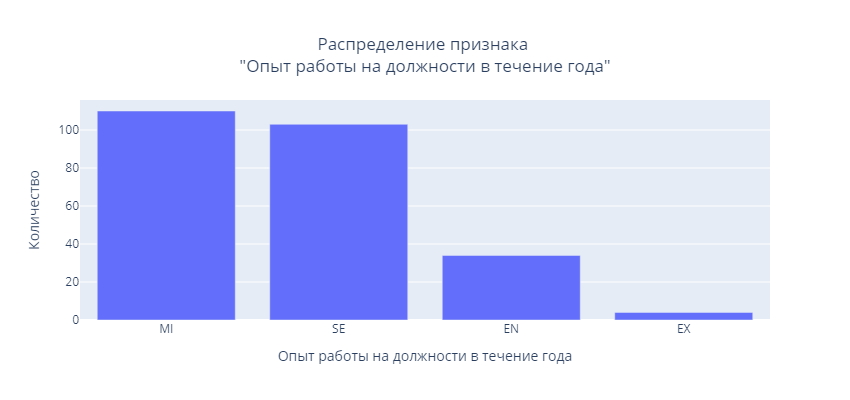

Статистические данные признака:


count     251
unique      4
top        MI
freq      110
Name: experience_level, dtype: object

Top-5 значений (%):


experience_level
MI    43.82
SE    41.04
EN    13.55
EX     1.59
Name: proportion, dtype: float64

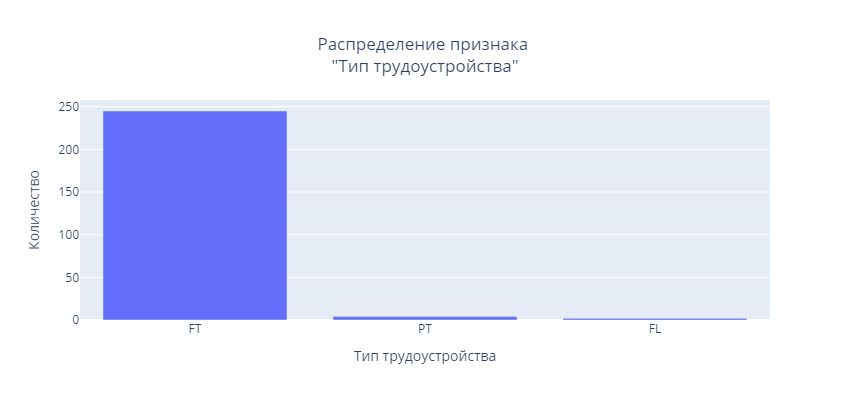

Статистические данные признака:


count     251
unique      3
top        FT
freq      245
Name: employment_type, dtype: object

Top-5 значений (%):


employment_type
FT    97.61
PT     1.59
FL     0.80
Name: proportion, dtype: float64

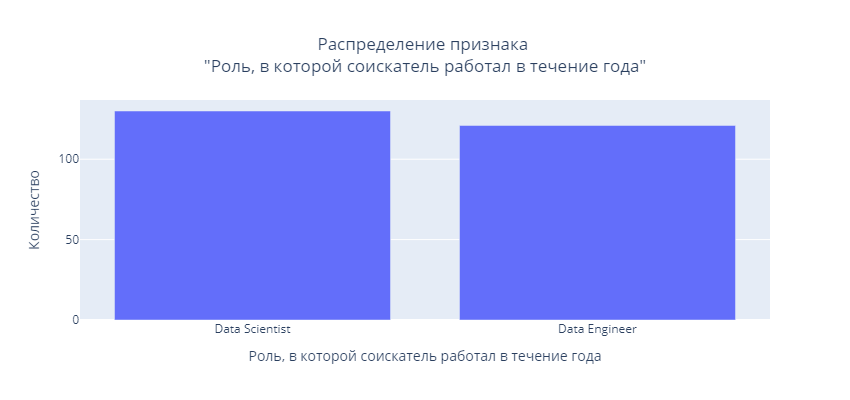

Статистические данные признака:


count                251
unique                 2
top       Data Scientist
freq                 130
Name: job_title, dtype: object

Top-5 значений (%):


job_title
Data Scientist    51.79
Data Engineer     48.21
Name: proportion, dtype: float64

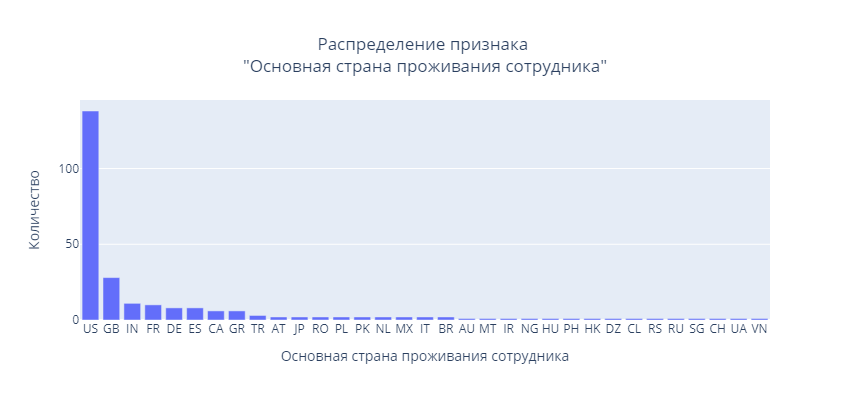

Статистические данные признака:


count     251
unique     33
top        US
freq      138
Name: employee_residence, dtype: object

Top-5 значений (%):


employee_residence
US    54.98
GB    11.16
IN     4.38
FR     3.98
DE     3.19
Name: proportion, dtype: float64

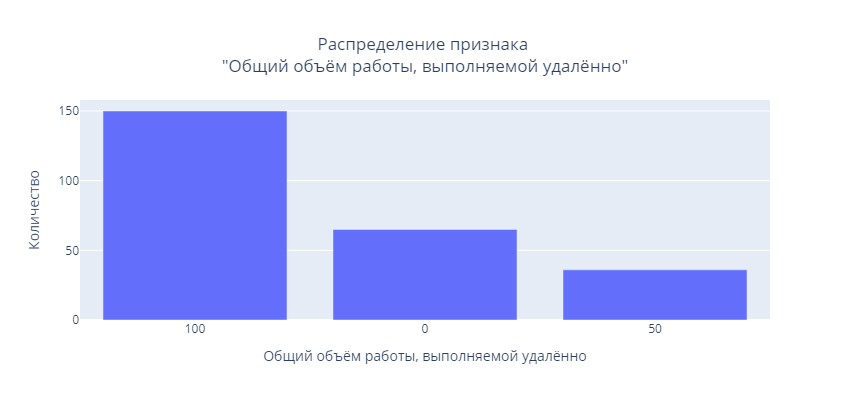

Статистические данные признака:


count     251
unique      3
top       100
freq      150
Name: remote_ratio, dtype: int64

Top-5 значений (%):


remote_ratio
100    59.76
0      25.90
50     14.34
Name: proportion, dtype: float64

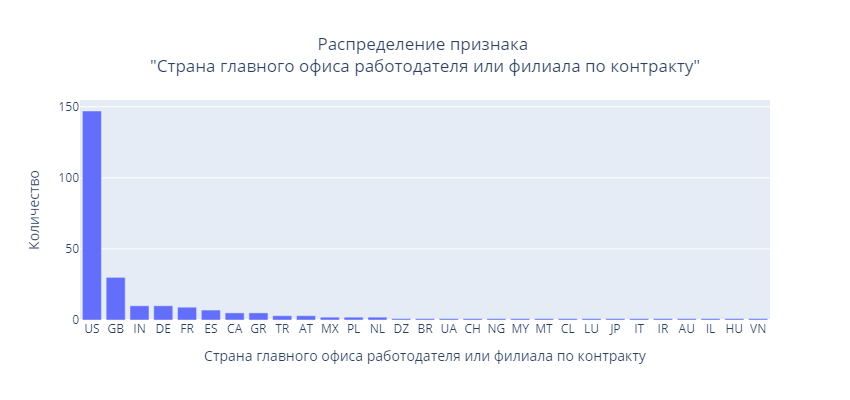

Статистические данные признака:


count     251
unique     29
top        US
freq      147
Name: company_location, dtype: object

Top-5 значений (%):


company_location
US    58.57
GB    11.95
IN     3.98
DE     3.98
FR     3.59
Name: proportion, dtype: float64

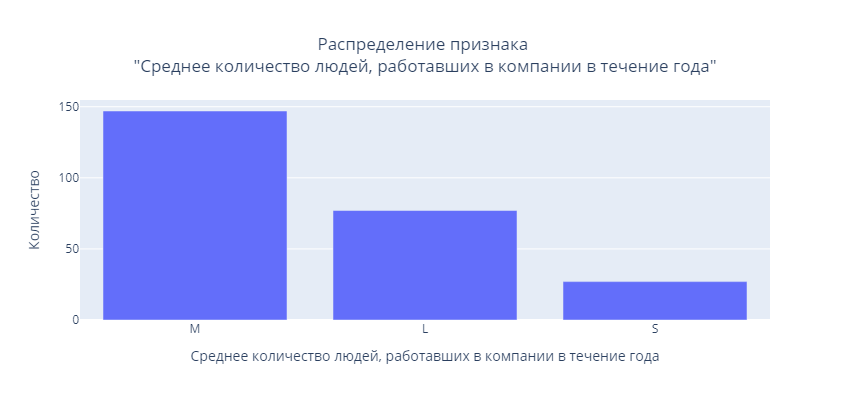

Статистические данные признака:


count     251
unique      3
top         M
freq      147
Name: company_size, dtype: object

Top-5 значений (%):


company_size
M    58.57
L    30.68
S    10.76
Name: proportion, dtype: float64

In [281]:
# Построение баров распределения каждого категориального признака
for col in df_ds_salaries_cleared.columns:
    if not pd.api.types.is_numeric_dtype(df_ds_salaries_cleared[col].dtype):
        # Инициализация полотна на два графика с общей осью X
        fig_col = go.Figure(data=go.Bar(x=df_ds_salaries_cleared[col].value_counts().index.astype(str),
                                        y=df_ds_salaries_cleared[col].value_counts()))
        # Размер полотна
        fig_col.update_layout(autosize = False, width = 850, height = 400)
        # Заголовок диаграммы
        fig_col.update_layout(title=f"Распределение признака <br>\"{dict_col_name_rus[col]}\"",
                              title_x=0.5, # Расположение посередине
                              xaxis_title=dict_col_name_rus[col], # Подпись Х
                              yaxis_title='Количество') # Подпись Y
        fig_col.show('png')
        
        print('Статистические данные признака:')
        display(df_ds_salaries_cleared[col].describe())
        print('Top-5 значений (%):')
        display(df_ds_salaries_cleared[col].value_counts(normalize=True).head(5).round(4)*100)

Признак **'Опыт работы на должности в течение года'**:  
Преобладает категория SE (Senior-level/Expert), за ней следует MI (Mid-level/Intermediate) и EN (Entry-level/Junior), наименьшее количество в категории EX (Executive-level/Director).  
Опыт работы на должности в течение года должен быть значимым для анализа зарплат.

Признак **'Тип трудоустройства'**:  
Явно преобладает категория FT (полный рабочий день), категории PT (неполный рабочий день) и FL (фриланс) крайне малы и сопоставимы по своему количеству между собой.  
Тип трудоустройства должен быть значимым при анализе заработной платы, однако, в данной выборке категория FT встречается в более чем 97% записей, записей по остальным категориям достаточно мало, поэтому выводы по ним могут быть недостоверны.

Признак **'Роль, в которой соискатель работал в течение года'**:  
По данному признаку была произведена фильтрация данных из исходного набора. В текущем состоянии признак содержит две категории: Data Scientist и Data Engineer, количество записей в Data Scientist преобладает незначительно, соответсвенно категории сопоставимы между собой, что позволяет провести корректный анализ по ключевым вопросам HR-агентства, в которых фигурирует сравнение показателей специалистов Data Scientist и Data Engineer.

Признак **'Основная страна проживания сотрудника'**:  
Наибольшая доля приходится на US (США) и GB (Великобритания) со значительным преобладанием US. Остальные 34% записей распределены в другой 31 категории признака.  
Страна проживания сотрудника может оказывать значительное влияние на размер его заработной платы.

Признак **'Общий объём работы, выполняемой удалённо'**:  
Преобладает категория 100 (полностью удалённая работа), за ней следует 0 (удалённой работы нет), наименьшее количество в категории 50 (частично удалённая работа).  
Общий объём работы, выполняемой удалённо, должен быть значимым для анализа зарплат.

Признак **'Страна главного офиса работодателя или филиала по контракту'**:  
Наибольшая доля приходится на US (США) и GB (Великобритания) со значительным преобладанием US. Остальные 30% записей распределены в других 27 категориях признака.  
Страна главного офиса работодателя может оказывать значительное влияние на размер его заработной платы.

Признак **'Среднее количество людей, работавших в компании в течение года'**:  
Преобладает категория M (средняя компания), за ней следует L (крупная компания), наименьшее количество в категории S (небольшая компания).  
Размер компании должен быть значимым для анализа зарплат.

#### Ключевые вопросы

##### 1. Размер заработной платы у специалистов Data Scientist по годам

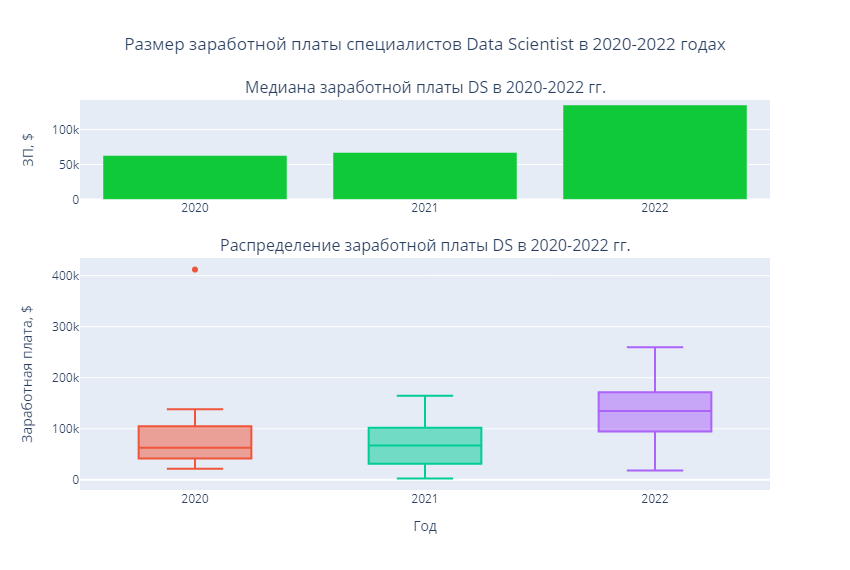

In [282]:
# Инициализация полотна
figure_salary_ds = make_subplots(rows=2, cols=1,
                                 subplot_titles=("Медиана заработной платы DS в 2020-2022 гг.", 
                                                 "Распределение заработной платы DS в 2020-2022 гг."),
                                 row_heights=[0.3, 0.7],
                                 vertical_spacing=0.15)
# Подготовка данных для отображения
df_median_salaries_DS = df_ds_salaries_cleared[mask_ds].groupby(by=['work_year'])['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds.add_trace(go.Bar(x=df_median_salaries_DS.index.astype(str),
                                  y=df_median_salaries_DS,
                                  showlegend=False,
                                  marker_color = '#10c938'), # Цвет маркера
                            row=1, col=1)
# Построение коробчатой диаграммы
for year in df_median_salaries_DS.index:
    mask_year = df_ds_salaries_cleared['work_year'] == year
    figure_salary_ds.add_trace(go.Box(y=df_ds_salaries_cleared[mask_ds & mask_year]['salary_in_usd'],
                                      showlegend=False,
                                      name=year), # Название набора данных
                               row=2, col=1)
# Размер полотна
figure_salary_ds.update_layout(autosize = False, width = 850, height = 570,
                               title='Размер заработной платы специалистов Data Scientist в 2020-2022 годах',
                               title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds.update_xaxes(title_text="Год", row = 2, col = 1)
figure_salary_ds.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds.show('png')

Здесь и для последующих расчетов из-за отсутствия признаков нормального распределения в данных о заработной плате в качестве меры центральной тенденции выбрана медиана значений.
Исходя из полученных графиков, у специалистов Data Scientist наблюдается ежегодный рост зарплат.

##### 2. Соотношение заработной платы Data Scientist и Data Engineer в 2022 году

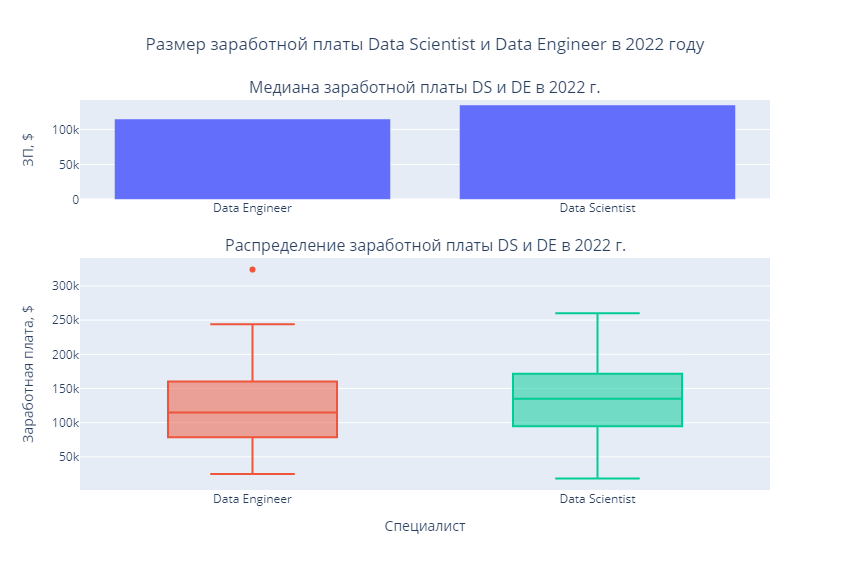

In [283]:
# Инициализация полотна
figure_salary_ds_de = make_subplots(rows=2, cols=1,
                                    subplot_titles=("Медиана заработной платы DS и DE в 2022 г.", 
                                                    "Распределение заработной платы DS и DE в 2022 г."),
                                    row_heights=[0.3, 0.7],
                                    vertical_spacing=0.15)
# Подготовка данных для отображения
mask_2022 = df_ds_salaries_cleared['work_year'] == 2022
df_median_salaries_2022 = df_ds_salaries_cleared[mask_2022].groupby(by=['job_title'], 
                                                                    observed=True)['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds_de.add_trace(go.Bar(x=df_median_salaries_2022.index,
                                     y=df_median_salaries_2022,
                                     name='',
                                     showlegend=False),
                              row=1, col=1)
# Построение коробчатой диаграммы
for title in df_median_salaries_2022.index:
    mask_title = df_ds_salaries_cleared['job_title'] == title
    figure_salary_ds_de.add_trace(go.Box(y=df_ds_salaries_cleared[mask_title & mask_2022]['salary_in_usd'],
                                         showlegend=False,
                                         name=title), # Название набора данных
                                  row=2, col=1)
# Размер полотна
figure_salary_ds_de.update_layout(autosize = False, width = 850, height = 570,
                                  title='Размер заработной платы Data Scientist и Data Engineer в 2022 году',
                                  title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds_de.update_xaxes(title_text="Специалист", row = 2, col = 1)
figure_salary_ds_de.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds_de.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds_de.show('png')

Исходя из полученных графиков, в 2022 году заработная плата специалистов Data Scientist выше, чем у специалистов Data Engineer.

##### 3. Соотношение заработной платы специалистов Data Scientist в компаниях различных размеров

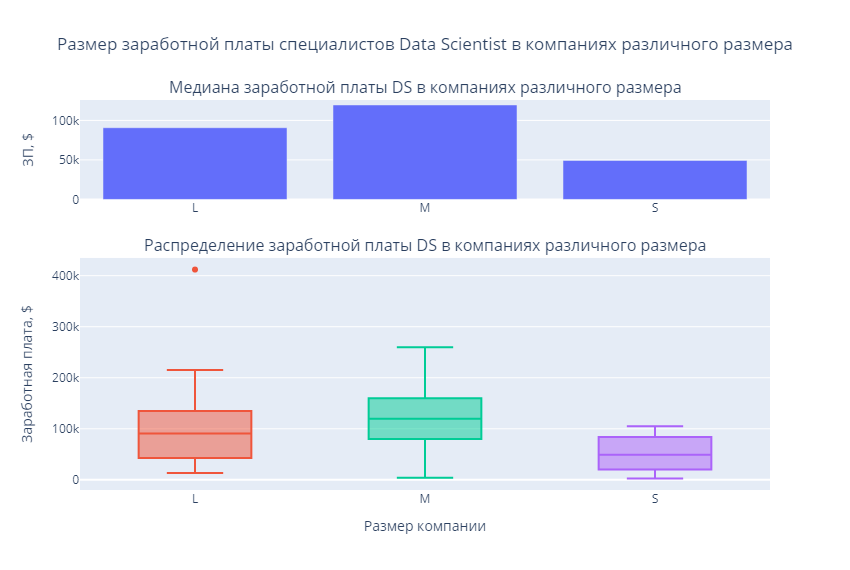

In [284]:
# Инициализация полотна
title_bar = "Медиана заработной платы DS в компаниях различного размера"
title_box = "Распределение заработной платы DS в компаниях различного размера"
figure_salary_ds_size_copm = make_subplots(rows=2, cols=1,
                                           subplot_titles=(title_bar, 
                                                           title_box),
                                           row_heights=[0.3, 0.7],
                                           vertical_spacing=0.15)
# Подготовка данных для отображения
df_median_salaries_ds_size_copm = df_ds_salaries_cleared[mask_ds].groupby(by=['company_size'], 
                                                                          observed=True)['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds_size_copm.add_trace(go.Bar(x=df_median_salaries_ds_size_copm.index,
                                            y=df_median_salaries_ds_size_copm,
                                            showlegend=False),
                                     row=1, col=1)
# Построение коробчатой диаграммы
for size in df_median_salaries_ds_size_copm.index:
    mask_size = df_ds_salaries_cleared['company_size'] == size
    figure_salary_ds_size_copm.add_trace(go.Box(y=df_ds_salaries_cleared[mask_size & mask_ds]['salary_in_usd'],
                                                showlegend=False,
                                                name=size), # Название набора данных
                                         row=2, col=1)
# Размер полотна
title_main = 'Размер заработной платы специалистов Data Scientist в компаниях различного размера'
figure_salary_ds_size_copm.update_layout(autosize=False, width = 850, height = 570,
                                         title=title_main,
                                         title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds_size_copm.update_xaxes(title_text="Размер компании", row = 2, col = 1)
figure_salary_ds_size_copm.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds_size_copm.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds_size_copm.show('png')

Распределение заработной платы специалистов Data Scientist в компаниях с разным штатом сотрудников различаются, при этом наиболее высокая зарплата ожидается в средних компаниях, такое различие по сравнению с крупными компаниями может объясняться наличием в крупных компаниях расширенных социальных гарантий и развитой дополнительной социальной инфраструктуры для своих сотрудников (спорт-залы, зоны отдыха и т.п.), а также, возможно, в крупных и средних компаниях масштабы решаемых задач соразмерны, но ввиду количества сотрудников, решающих их, итоговая нагрузка на каждого специалиста в отдельности в средних компаниях выше.

##### 4. Связь между наличием должностей Data Scientist и Data Engineer и размером компании

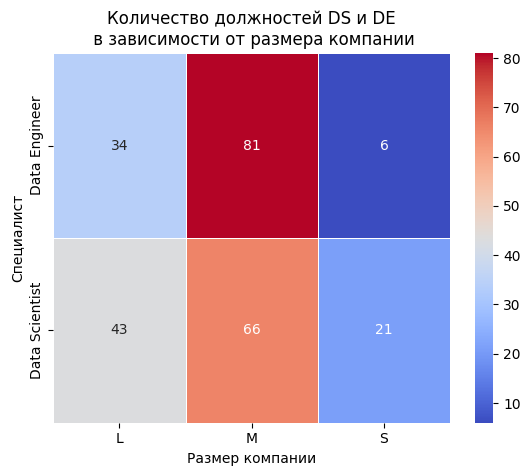

In [285]:
# Построение таблицы сопряженности
cross_tab = pd.crosstab(index=df_ds_salaries_cleared['job_title'], 
                        columns=df_ds_salaries_cleared['company_size'])
# Построение тепловой карты
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Специалист')
plt.title('Количество должностей DS и DE\n в зависимости от размера компании')
plt.show('png')

Согласно тепловой карте наибольшее количество специалистов Data Scientist и Data Engineer наблюдается в средних компаниях, причем количество специалистов Data Engineer имеет максимальное значение. При этом минимальное значение наблюдается также у специалистов этой категории в малых компаниях. Таким образом, возможно наличие взаимосвязи между наличием должностей Data Scientist и Data Engineer и размером компании.

#### Обзор взаимосвязи заработной платы специалистов с остальными признаками

##### 1. Зависимость размера заработной платы от опыта работы на должности в течение года

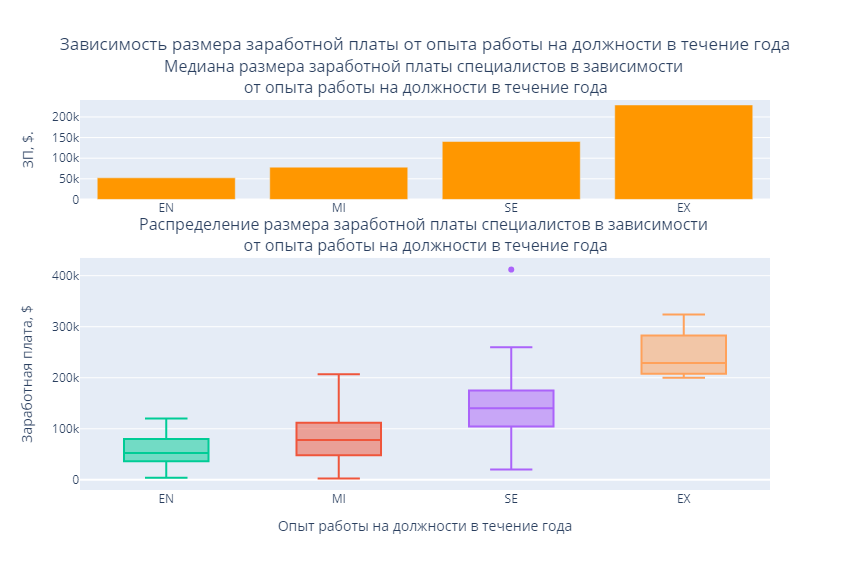

In [286]:
# Инициализация полотна
title_bar = "Медиана размера заработной платы специалистов в зависимости <br>\
от опыта работы на должности в течение года"
title_box = "Распределение размера заработной платы специалистов в зависимости <br>\
от опыта работы на должности в течение года"
figure_salaries_experience = make_subplots(rows=2, cols=1,
                                           subplot_titles=(title_bar, 
                                                           title_box),
                                           row_heights=[0.3, 0.7],
                                           vertical_spacing=0.15)
# Построение баров
displayed_data = df_ds_salaries_cleared.groupby('experience_level', 
                                                observed=True)['salary_in_usd'].median()
figure_salaries_experience.add_trace(go.Bar(x=displayed_data.index,
                                            y=displayed_data,
                                            showlegend=False,
                                            name='Опыт работы на должности в течение года',
                                            marker_color = '#FF9700'), # Цвет маркера
                                     row=1, col=1)

# Построение коробчатой диаграммы
for cat in df_ds_salaries_cleared['experience_level'].unique():
    mask_cat = df_ds_salaries_cleared['experience_level'] == cat
    figure_salaries_experience.add_trace(go.Box(y=df_ds_salaries_cleared[mask_cat]['salary_in_usd'],
                                                showlegend=False,
                                                name=cat), # Название набора данных
                                         row=2, col=1)
# Размер полотна
title_main = 'Зависимость размера заработной платы от опыта работы на должности в течение года'
figure_salaries_experience.update_layout(autosize = False, width = 850, height = 570,
                                         title=title_main,
                                         title_x=0.5) # Выравнивание заголовка посередине
# Порядок вывода категорий
figure_salaries_experience.update_xaxes(categoryorder='array',
                                        categoryarray=["EN", "MI", "SE", "EX"])   
# Подпись осей
figure_salaries_experience.update_xaxes(title_text="Опыт работы на должности в течение года", row = 2, col = 1)
figure_salaries_experience.update_yaxes(title_text="ЗП, $.", row = 1, col = 1)
figure_salaries_experience.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)

figure_salaries_experience.show('png')

Наблюдается прямая зависимость размера заработной платы от опыта работы на должности в течение года: с возрастанием опыта работы заработная плата также растет.

##### 2. Зависимость размера заработной платы от типа трудоустройства

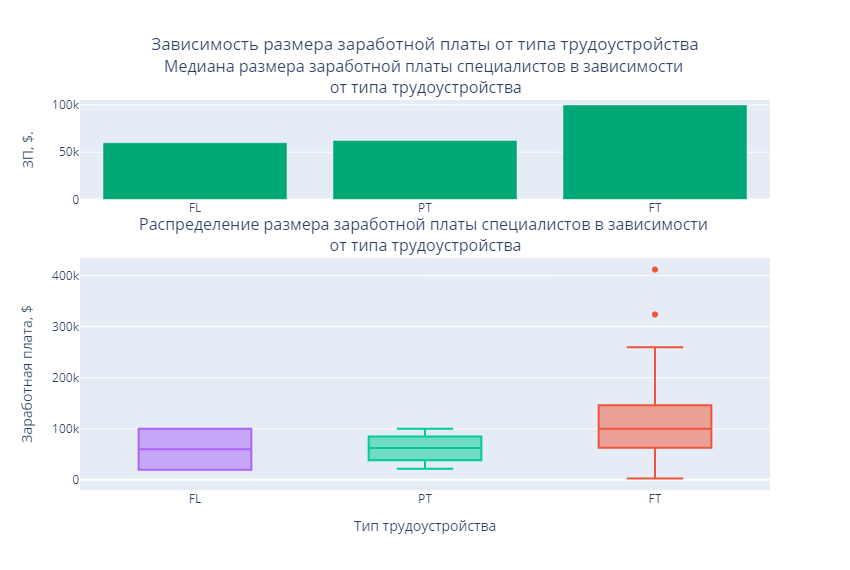

In [287]:
# Инициализация полотна
title_bar = "Медиана размера заработной платы специалистов в зависимости <br>от типа трудоустройства"
title_box = "Распределение размера заработной платы специалистов в зависимости <br>от типа трудоустройства"
figure_salaries_employment = make_subplots(rows=2, cols=1,
                                           subplot_titles=(title_bar, 
                                                           title_box),
                                           row_heights=[0.3, 0.7],
                                           vertical_spacing=0.15)
# Подготовка данных для отображения
displayed_data = df_ds_salaries_cleared.groupby('employment_type', observed=True)['salary_in_usd'].median()
# Построение баров
figure_salaries_employment.add_trace(go.Bar(x=displayed_data.index,
                                            y=displayed_data,
                                            showlegend=False,
                                            name='Тип трудоустройства',
                                            marker_color = '#00A876'), # Цвет маркера
                                     row=1, col=1)
# Построение коробчатой диаграммы
for cat in df_ds_salaries_cleared['employment_type'].unique():
    mask_cat = df_ds_salaries_cleared['employment_type'] == cat
    figure_salaries_employment.add_trace(go.Box(y=df_ds_salaries_cleared[mask_cat]['salary_in_usd'],
                                                showlegend=False,
                                                name=cat), # Название набора данных
                                         row=2, col=1)
# Размер полотна
figure_salaries_employment.update_layout(autosize = False, width = 850, height = 570,
                                         title='Зависимость размера заработной платы от типа трудоустройства',
                                         title_x=0.5) # Выравнивание заголовка посередине
# Порядок вывода категорий
figure_salaries_employment.update_xaxes(categoryorder='array',
                                        categoryarray=["FL", "PT", "FT"])   
# Подпись осей
figure_salaries_employment.update_xaxes(title_text="Тип трудоустройства", row = 2, col = 1)
figure_salaries_employment.update_yaxes(title_text="ЗП, $.", row = 1, col = 1)
figure_salaries_employment.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)

figure_salaries_employment.show('png')

Медианные значения заработной платы специалистов Data Scientist и Data Engineer в категориях FL (фриланс) и PT (неполный рабочий день) позволяют предположить равенство зарплат при данных типах трудоустройства, для FT (полный рабочий день) это значение выше, но распределение в данной категории захватывает полный спектр значений для остальных двух категорий, диаграммы распределений категорий FL и PT также различны, что показывает необходимость в проведении статистических тестов.

##### 3. Зависимость размера заработной платы от общего объёма работы, выполняемой удалённо

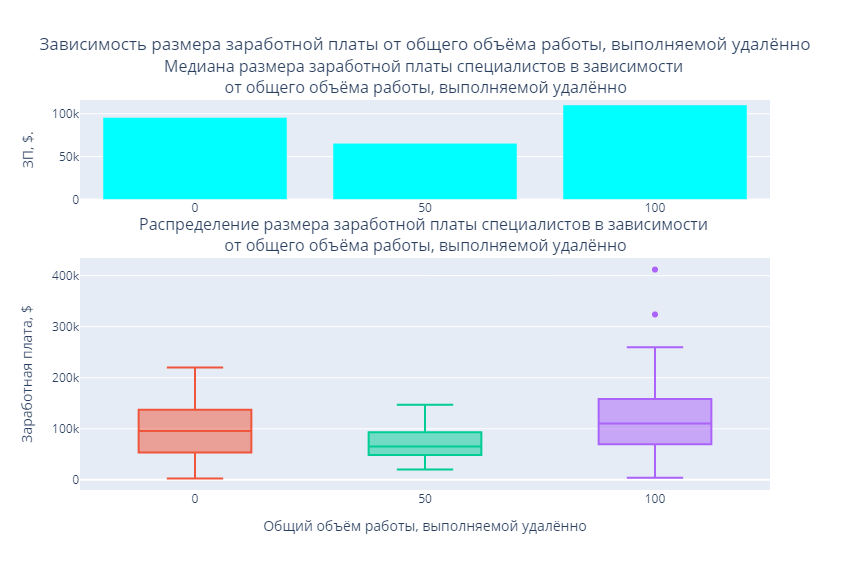

In [288]:
# Инициализация полотна
title_bar = "Медиана размера заработной платы специалистов в зависимости <br>\
от общего объёма работы, выполняемой удалённо"
title_box = "Распределение размера заработной платы специалистов в зависимости <br>\
от общего объёма работы, выполняемой удалённо"
figure_salaries_remote_ratio = make_subplots(rows=2, cols=1,
                                             subplot_titles=(title_bar, 
                                                             title_box),
                                             row_heights=[0.3, 0.7],
                                             vertical_spacing=0.15)
# Подготовка данных для отображения
displayed_data = df_ds_salaries_cleared.groupby('remote_ratio', observed=True)['salary_in_usd'].median()
# Построение баров
figure_salaries_remote_ratio.add_trace(go.Bar(x=displayed_data.index.astype('str'),
                                              y=displayed_data,
                                              showlegend=False,
                                              name='Общий объём работы, выполняемой удалённо',
                                              marker_color = 'Cyan'), # Цвет маркера
                                       row=1, col=1)
# Построение коробчатой диаграммы
for cat in df_ds_salaries_cleared['remote_ratio'].unique():
    mask_cat = df_ds_salaries_cleared['remote_ratio'] == cat
    figure_salaries_remote_ratio.add_trace(go.Box(y=df_ds_salaries_cleared[mask_cat]['salary_in_usd'],
                                                  showlegend=False,
                                                  name=cat), # Название набора данных
                                           row=2, col=1)
# Размер полотна
title_main = 'Зависимость размера заработной платы от общего объёма работы, выполняемой удалённо'
figure_salaries_remote_ratio.update_layout(autosize = False, width = 850, height = 570,
                                           title=title_main,
                                           title_x=0.5) # Выравнивание заголовка посередине
# Подпись осей
figure_salaries_remote_ratio.update_xaxes(title_text="Общий объём работы, выполняемой удалённо", row = 2, col = 1)
figure_salaries_remote_ratio.update_yaxes(title_text="ЗП, $.", row = 1, col = 1)
figure_salaries_remote_ratio.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)

figure_salaries_remote_ratio.show('png')

Медианные значения заработной платы специалистов Data Scientist и Data Engineer при всех вариантах объема работы, выполняемой удаленно, различны. При этом минимальное значение наблюдается в категории 50 (частично удаленная работа), максимальное - в категории 100 (полностью удалённая работа).

##### 4. Зависимость размера заработной платы от страны главного офиса работодателя или филиала по контракту

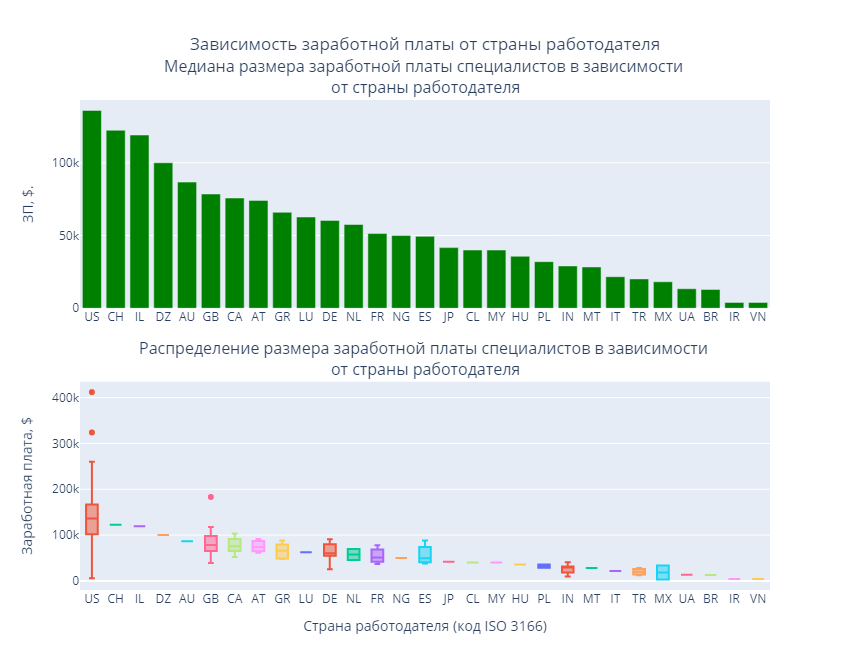

In [289]:
# Инициализация полотна
title_bar = "Медиана размера заработной платы специалистов в зависимости <br>от страны работодателя"
title_box = "Распределение размера заработной платы специалистов в зависимости <br>от страны работодателя"
figure_salaries_country = make_subplots(rows=2, cols=1,
                                        subplot_titles=(title_bar, 
                                                        title_box),
                                        row_heights=[0.5, 0.5],
                                        vertical_spacing=0.15)
# Подготовка данных для отображения
displayed_data = df_ds_salaries_cleared.groupby('company_location', 
                                                observed=True)['salary_in_usd'].median().sort_values(ascending=False)
# Построение баров
figure_salaries_country.add_trace(go.Bar(x=displayed_data.index,
                                         y=displayed_data,
                                         showlegend=False,
                                         name='Страна работодателя',
                                         marker_color = 'Green'), # Цвет маркера
                                  row=1, col=1)
# Построение коробчатой диаграммы
for cat in displayed_data.index:
    mask_cat = df_ds_salaries_cleared['company_location'] == cat
    figure_salaries_country.add_trace(go.Box(y=df_ds_salaries_cleared[mask_cat]['salary_in_usd'],
                                             showlegend=False,
                                             name=cat), # Название набора данных
                                      row=2, col=1)
# Размер полотна
figure_salaries_country.update_layout(autosize = False, width = 850, height = 670,
                                      title='Зависимость заработной платы от страны работодателя',
                                      title_x=0.5) # Выравнивание заголовка посередине
# Подпись осей
figure_salaries_country.update_xaxes(title_text="Страна работодателя (код ISO 3166)", row = 2, col = 1)
figure_salaries_country.update_yaxes(title_text="ЗП, $.", row = 1, col = 1)
figure_salaries_country.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)

figure_salaries_country.show('png')

Заработная плата специалистов Data Scientist и Data Engineer зависит от страны главного офиса работодателя или филиала по контракту.

##### 5. Зависимость размера заработной платы сотрудников, проживающих в стране главного офиса работодателя, и сотрудников, проживающих за ее пределами

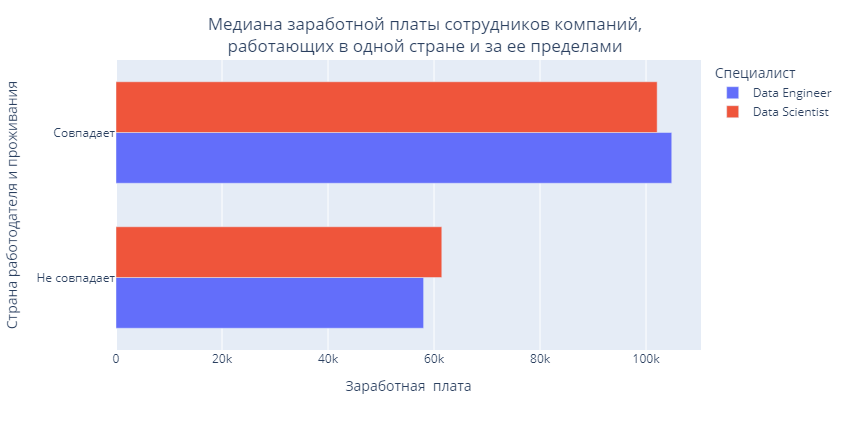

In [290]:
# Подготовка данных для отображения
list_columns = ['salary_in_usd', 'job_title', 'employee_residence', 'company_location']
df_median_salaries = df_ds_salaries_cleared[list_columns].copy()
df_median_salaries['employee_residence'] = df_median_salaries['employee_residence'].astype(str)
df_median_salaries['company_location'] = df_median_salaries['company_location'].astype(str)
# Создание признака совпадения страны проживания и страны работодателя
df_median_salaries['company_loc_is_empl_residence'] = np.where(df_median_salaries['employee_residence'] 
                                                               == df_median_salaries['company_location'],
                                                               'Совпадает', 'Не совпадает')
# Подготовка данных для отображения
pt_us = df_median_salaries.groupby(by=['job_title', 'company_loc_is_empl_residence'], 
                                   observed=True, as_index=False)['salary_in_usd'].median()
pt_us.rename(columns={"job_title": "Специалист", 
                      "company_loc_is_empl_residence": "Страна работодателя и проживания", 
                      "salary_in_usd": "Заработная  плата"},
             inplace=True)
# Построение баров
figure_salary_us= px.bar(data_frame=pt_us,
                         y='Страна работодателя и проживания',
                         x='Заработная  плата',
                         barmode="group",
                         orientation='h',
                         color='Специалист')
figure_salary_us.update_layout(autosize = False, width = 850, height = 430, # Размер полотна
                               bargap=0.3) # Расстояние между столбцами
# Заголовк и подписи осей
figure_salary_us.update_layout(title='Медиана заработной платы сотрудников компаний,<br>\
работающих в одной стране и за ее пределами',
                               title_x=0.5) # Выравнивание заголовка посередине
figure_salary_us.show('png')

При рассмотрении уровня заработной платы сотрудников компании, работающих в стране главного офиса работодателя и за ее пределами, прослеживается закономерность, что при найме сотрудников за пределами страны главного офиса работодателя заработная плата ниже. При этом разница между зарплатами Data Scientist и Data Engineer не столь существенна. Данный факт может быть связан с тем, что в большинстве случаев компании обеспечивают средний уровень заработной платы по стране ее расположения и не нанимает сотрудников за ее пределами в странах с более высоким уровнем доходов, а наоборот, ищет сотрудников в странах с меньшим средним уровнем зарплаты, что позволяет ей сэкономить, даже предложив более высокую зарплату, чем средняя по стране проживания соискателя.

Таким образом, на заработную плату влияют следующие факторы:
- роль, в которой соискатель работал в течении года;
- размер компании;
- опыта работы на должности в течение года;
- тип трудоустройства;
- режим работы (общий объём работы, выполняемой удалённо);
- страна работодателя;
- является ли страна работодателя страной проживания сотрудника;
- также ежегодно заработная плата увеличивается.

### Статистический анализ данных

In [291]:
def decision_normality(p):
    '''Функция вывода информации о нормальности распределения
       на основании p-value при сравнении с alpha = 0.05'''
       
    alpha = 0.05
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(f'p-value меньше заданного уровеня значимости {alpha:.2f}. Распределение отлично от нормального')
    else:
        print(f'p-value больше заданного уровеня значимости {alpha:.2f}. Распределение является нормальным')


def decision_hypothesis(p):
    '''Функция вывода информации об отклонении нулевой гипотезы
       на основании p-value при сравнении с alpha = 0.05'''
       
    alpha = 0.05
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(f'p-value меньше заданного уровеня значимости {alpha:.2f}. Отвергаем нулевую гипотезу.')
    else:
        print(f'p-value больше заданного уровеня значимости {alpha:.2f}. Нет оснований отвергнуть нулевую гипотезу.')
      

#### Ключевые вопросы

##### 1. Размер заработной платы у специалистов Data Scientist по годам

В ходе визуального анализа предполагается, что у специалистов Data Scientist наблюдается ежегодный рост зарплат.  
С учетом формулировки поставленного вопроса, так как многовыборочные статистические тесты (для трех групп и более) позволяют проверить гипотезы только о равенстве/неравенстве показателей для категорий, окончательный вывод можно сделать, получив результаты проверки двух статистических гипотез:
1) размер заработной платы у специалистов Data Scientist в 2021 году больше, чем в 2020;
2) размер заработной платы у специалистов Data Scientist в 2022 году больше, чем в 2021.

Пусть $μ_1$ - зарплата Data Scientist за 2020 год, $μ_2$ - за 2021, $μ_3$ - за 2022. 

**Определение нулевой и альтернативной гипотез**  
**1) 2020 - 2021 гг.:**  
*Нулевая гипотеза* ($H_0$): размер зарплаты Data Scientist за 2020 год статистически больше либо равен размеру зарплаты Data Scientist за 2021 год.
$$ H_0 : μ_1 >= μ_2$$
*Альтернативная гипотеза* ($H_1$): размер зарплаты Data Scientist за 2020 год статистически меньше размера зарплаты Data Scientist за 2021 год.
$$ H_1 : μ_1 < μ_2$$
**2) 2021 - 2022 гг.:**  
*Нулевая гипотеза* ($H_0$): размер зарплаты Data Scientist за 2021 год статистически больше либо равен размеру зарплаты Data Scientist за 2022 год.
$$ H_0 : μ_2 >= μ_3$$
*Альтернативная гипотеза* ($H_1$): размер зарплаты Data Scientist за 2021 год статистически меньше размера зарплаты Data Scientist за 2022 год.
$$ H_1 : μ_2 < μ_3$$

In [292]:
# Проверка на нормальность значения зарплат по годам
# Выборка данных
mask_2020 = df_ds_salaries_cleared['work_year'] == 2020
mask_2021 = df_ds_salaries_cleared['work_year'] == 2021
salary_ds_2020 = df_ds_salaries_cleared[mask_ds & mask_2020]['salary_in_usd']
salary_ds_2021 = df_ds_salaries_cleared[mask_ds & mask_2021]['salary_in_usd']
salary_ds_2022 = df_ds_salaries_cleared[mask_ds & mask_2022]['salary_in_usd']

# Тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(salary_ds_2020)
decision_normality(result[1])

print('2021:')
result = stats.shapiro(salary_ds_2021)
decision_normality(result[1])

print('2022:')
result = stats.shapiro(salary_ds_2022)
decision_normality(result[1])

2020:
p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.107
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
2022:
p-value = 0.676
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным


**Выбор статистического теста**  
**1) 2020 - 2021 гг.:**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Две.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет.

Для проверки гипотезы выбран U-критерий Манна — Уитни.

**2) 2021 - 2022 гг.:**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Две.
* Зависимость групп — отсутствует.
* Нормальность распределения — Да.

Для проверки гипотезы выбран двухвыборочный t-критерий.

**Проведение тестов**

In [293]:
# 2020-2021
_, p = stats.mannwhitneyu(salary_ds_2020, salary_ds_2021, alternative='less')
decision_hypothesis(p)

p-value = 0.705
p-value больше заданного уровеня значимости 0.05. Нет оснований отвергнуть нулевую гипотезу.


In [294]:
# 2021-2022
# Тест Левена на равенство дисперсий
print('Тест на равенство дисперсий:')
result = stats.levene(salary_ds_2021, salary_ds_2022)
p_levene = result[1]
sal_equal_var=(p_levene > 0.05)
# Интерпретация результата
if p_levene <= 0.05:
    print('Дисперсии не одинаковы.')
else:
    print('Дисперсии одинаковы.')
# Тестирование
_, p = stats.ttest_ind(salary_ds_2021, salary_ds_2022, alternative='less', equal_var=sal_equal_var)
decision_hypothesis(p)

Тест на равенство дисперсий:
Дисперсии одинаковы.
p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер заработной платы у специалистов Data Scientist в 2021 году больше, чем в 2020.  
Размер заработной платы у специалистов Data Scientist в 2022 году больше, чем в 2021.  

Таким образом, на базе предоставленных данных нет оснований утверждать, что наблюдается ежегодный рост зарплат у специалистов Data Scientist.

##### 2. Соотношение заработной платы Data Scientist и Data Engineer в 2022 году

В ходе визуального анализа предполагается, что в 2022 году заработная плата специалистов Data Scientist выше, чем у специалистов Data Engineer.

**Определение нулевой и альтернативной гипотез**  
*Нулевая гипотеза* ($H_0$): в 2022 году заработная плата специалистов Data Scientist ($μ_1$) равна или меньше заработной платы специалистов Data Engineer ($μ_2$).
$$ H_0 : μ_1 <= μ_2$$
*Альтернативная гипотеза* ($H_1$): в 2022 году заработная плата специалистов Data Scientist ($μ_1$) больше заработной платы специалистов Data Engineer ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

In [295]:
# Проверка на нормальность
# Выборка данных
salary_de_2022 = df_ds_salaries_cleared[mask_de & mask_2022]['salary_in_usd']
salary_ds_2022 = df_ds_salaries_cleared[mask_ds & mask_2022]['salary_in_usd']

# Тест Шапиро-Уилка
print('Data Scientist в 2022:')
result = stats.shapiro(salary_ds_2022)
decision_normality(result[1])

print('Data Engineer в 2022:')
result = stats.shapiro(salary_de_2022)
decision_normality(result[1])

Data Scientist в 2022:
p-value = 0.676
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
Data Engineer в 2022:
p-value = 0.007
p-value меньше заданного уровеня значимости 0.05. Распределение отлично от нормального


**Выбор статистического теста**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Две.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет.

Для проверки гипотезы выбран U-критерий Манна — Уитни.

**Проведение теста**

In [296]:
_, p = stats.mannwhitneyu(salary_ds_2022, salary_de_2022, alternative='greater')
decision_hypothesis(p)

p-value = 0.160
p-value больше заданного уровеня значимости 0.05. Нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что в 2022 году размер заработной платы специалистов Data Scientist больше заработной платы у специалистов Data Engineer

##### 3. Соотношение заработной платы специалистов Data Scientist в компаниях различных размеров

В ходе визуального анализа предполагается, что заработная плата специалистов Data Scientist в компаниях с разным штатом сотрудников различаются.

**Определение нулевой и альтернативной гипотез**  
*Нулевая гипотеза* ($H_0$): заработная плата специалистов Data Scientist в малых компаниях ($μ_1$) равна зарплате в средних ($μ_2$) и в крупных компаниях ($μ_3$).
$$ H_0 : μ_1 = μ_2 = μ_3$$
*Альтернативная гипотеза* ($H_1$): заработная плата специалистов Data Scientist в малых ($μ_1$), в средних ($μ_2$) и в крупных компаниях ($μ_3$) различны.
$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [297]:
# Проверка на нормальность
# Выборка данных
mask_s = df_ds_salaries_cleared['company_size'] == 'S'
mask_m = df_ds_salaries_cleared['company_size'] == 'M'
mask_l = df_ds_salaries_cleared['company_size'] == 'L'
salary_ds_s = df_ds_salaries_cleared[mask_ds & mask_s]['salary_in_usd']
salary_ds_m = df_ds_salaries_cleared[mask_ds & mask_m]['salary_in_usd']
salary_ds_l = df_ds_salaries_cleared[mask_ds & mask_l]['salary_in_usd']

# Тест Шапиро-Уилка
print('Size S:')
result = stats.shapiro(salary_ds_s)
decision_normality(result[1])

print('Size M:')
result = stats.shapiro(salary_ds_m)
decision_normality(result[1])

print('Size L:')
result = stats.shapiro(salary_ds_l)
decision_normality(result[1])

Size S:
p-value = 0.189
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
Size M:
p-value = 0.897
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
Size L:
p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Распределение отлично от нормального


**Выбор статистического теста**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Три.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет.

Для проверки гипотезы выбран критерий Краскела-Уоллиса.

**Проведение теста**

In [298]:
_, p = stats.kruskal(salary_ds_s, salary_ds_m, salary_ds_l)
decision_hypothesis(p)

p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Размер заработной платы специалистов Data Scientist отличается в компаниях различных размеров.

##### 4. Связь между наличием должностей Data Scientist и Data Engineer и размером компании

В ходе визуального анализа предполагается взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

**Определение нулевой и альтернативной гипотез**  
*Нулевая гипотеза* ($H_0$): взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании отсутствует (признаки независимы).  
*Альтернативная гипотеза* ($H_1$): присутствует взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании (признаки зависимы).

**Выбор статистического теста**  
* Тип признаков — Категориальный.
* Количество сравниваемых групп — Две.
* Зависимость групп — отсутствует.

Для проверки гипотезы выбран критерий ${\chi}^2$ (хи-квадрат).

**Проведение теста**

In [299]:
# Построение таблицы сопряженности
cross_tab = pd.crosstab(index=df_ds_salaries_cleared['job_title'], 
                        columns=df_ds_salaries_cleared['company_size'])
cross_tab

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


In [300]:
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.005
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Присутствует взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании, то есть признаки зависимы.

#### Обзор взаимосвязи заработной платы специалистов с остальными признаками

##### 1. Зависимость размера заработной платы от опыта работы на должности в течение года

В ходе визуального анализа предполагается, что присутствует прямая зависимость размера заработной платы от опыта работы на должности в течение года: с возрастанием опыта работы заработная плата также растет. С учетом формулировки поставленного вопроса, так как многовыборочные статистические тесты (для трех групп и более) позволяют проверить гипотезы только о равенстве/неравенстве показателей для категорий, окончательный вывод можно сделать, получив результаты проверки трех статистических гипотез:
1) размер заработной платы у специалистов с опытом работы на должности в течение года EN меньше, чем MI;
2) размер заработной платы у специалистов с опытом работы на должности в течение года MI меньше, чем SE;
3) размер заработной платы у специалистов с опытом работы на должности в течение года SE меньше, чем EX.

Пусть $μ_1$ - зарплата с опытом EN, $μ_2$ - MI, $μ_3$ - SE, $μ_4$ - EX. 

**Определение нулевой и альтернативной гипотез**  
**1) EN - MI:**  
*Нулевая гипотеза* ($H_0$): размер заработной платы у специалистов с опытом работы на должности в течение года EN равен или больше, чем MI.
$$ H_0 : μ_1 >= μ_2$$
*Альтернативная гипотеза* ($H_1$): размер заработной платы у специалистов с опытом работы на должности в течение года EN меньше, чем MI.
$$ H_1 : μ_1 < μ_2$$
**2) MI - SE:**  
*Нулевая гипотеза* ($H_0$): размер заработной платы у специалистов с опытом работы на должности в течение года MI равен или больше, чем SE.
$$ H_0 : μ_2 >= μ_3$$
*Альтернативная гипотеза* ($H_1$): размер заработной платы у специалистов с опытом работы на должности в течение года MI меньше, чем SE.
$$ H_1 : μ_2 < μ_3$$
**3) SE - EX:**  
*Нулевая гипотеза* ($H_0$): размер заработной платы у специалистов с опытом работы на должности в течение года SE равен или больше, чем EX.
$$ H_0 : μ_3 >= μ_4$$
*Альтернативная гипотеза* ($H_1$): размер заработной платы у специалистов с опытом работы на должности в течение года SE меньше, чем EX.
$$ H_1 : μ_3 < μ_4$$

In [301]:
# Проверка на нормальность
# Выборка данных
mask_en = df_ds_salaries_cleared['experience_level'] == 'EN'
mask_mi = df_ds_salaries_cleared['experience_level'] == 'MI'
mask_se = df_ds_salaries_cleared['experience_level'] == 'SE'
mask_ex = df_ds_salaries_cleared['experience_level'] == 'EX'
salary_en = df_ds_salaries_cleared[mask_en]['salary_in_usd']
salary_mi = df_ds_salaries_cleared[mask_mi]['salary_in_usd']
salary_se = df_ds_salaries_cleared[mask_se]['salary_in_usd']
salary_ex = df_ds_salaries_cleared[mask_ex]['salary_in_usd']

# Тест Шапиро-Уилка
print('Experience EN:')
result = stats.shapiro(salary_en)
decision_normality(result[1])

print('Experience MI:')
result = stats.shapiro(salary_mi)
decision_normality(result[1])

print('Experience SE:')
result = stats.shapiro(salary_se)
decision_normality(result[1])

print('Experience EX:')
result = stats.shapiro(salary_ex)
decision_normality(result[1])

Experience EN:
p-value = 0.557
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
Experience MI:
p-value = 0.051
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
Experience SE:
p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Распределение отлично от нормального
Experience EX:
p-value = 0.337
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным


**Выбор статистического теста**  
**1) EN - MI:**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Две.
* Зависимость групп — отсутствует.
* Нормальность распределения — Да.

Для проверки гипотезы выбран двухвыборочный t-критерий.

**2) MI - SE:**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Две.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет.

Для проверки гипотезы выбран U-критерий Манна — Уитни.

**3) SE - EX:**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Две.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет.

Для проверки гипотезы выбран U-критерий Манна — Уитни.

**Проведение тестов**

In [302]:
# EN-MI
# Тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_en, salary_mi)
p_levene = result[1]
sal_equal_var=(p_levene > 0.05)
# Интерпретация результата
if p_levene <= 0.05:
    print('Дисперсии не одинаковы.')
else:
    print('Дисперсии одинаковы.')
# Тестирование
_, p = stats.ttest_ind(salary_en, salary_mi, alternative='less', equal_var=sal_equal_var)
decision_hypothesis(p)

Тест на равенство дисперсий
Дисперсии не одинаковы.
p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


In [303]:
# MI-SE
_, p = stats.mannwhitneyu(salary_mi, salary_se, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


In [304]:
# SE-EX
_, p = stats.mannwhitneyu(salary_se, salary_ex, alternative='less')
decision_hypothesis(p)

p-value = 0.002
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

По результатам тестирования отвергнуты все три нулевых гипотезы в пользу альтернативных, таким образом, статистически подтверждена прямая зависимость размера заработной платы от опыта работы на должности в течение года.

##### 2. Зависимость размера заработной платы от типа трудоустройства

В ходе визуального анализа предполагается зависимость значений заработной платы специалистов Data Scientist и Data Engineer от типа трудоустройства (FL - фриланс, PT - неполный рабочий день, FT - полный рабочий день).

**Определение нулевой и альтернативной гипотез**  
*Нулевая гипотеза* ($H_0$): заработная плата специалистов с типом трудоустройства FL ($μ_1$) равна зарплате с типом PT ($μ_2$) и FT ($μ_3$).
$$ H_0 : μ_1 = μ_2 = μ_3$$
*Альтернативная гипотеза* ($H_1$):  заработная плата специалистов с типом трудоустройства FL ($μ_1$), PT ($μ_2$) и FT ($μ_3$) различны.
$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [305]:
# Проверка на нормальность
# Выборка данных
mask_fl = df_ds_salaries_cleared['employment_type'] == 'FL'
mask_pt = df_ds_salaries_cleared['employment_type'] == 'PT'
mask_ft = df_ds_salaries_cleared['employment_type'] == 'FT'
salary_fl = df_ds_salaries_cleared[mask_fl]['salary_in_usd']
salary_pt = df_ds_salaries_cleared[mask_pt]['salary_in_usd']
salary_ft = df_ds_salaries_cleared[mask_ft]['salary_in_usd']

# Тест Шапиро-Уилка
print('employment_type FL:')
result = stats.shapiro(salary_fl)
decision_normality(result[1])

print('employment_type PT:')
result = stats.shapiro(salary_pt)
decision_normality(result[1])

print('employment_type FT:')
result = stats.shapiro(salary_ft)
decision_normality(result[1])

employment_type FL:
p-value = nan
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
employment_type PT:
p-value = 0.989
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
employment_type FT:
p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Распределение отлично от нормального


C:\Users\g-022\AppData\Local\Temp\ipykernel_14760\1865218250.py:12: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



**Выбор статистического теста**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Три.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет (одна из выборок (FL) слишком мала для определения нормальности распределения, а также в условиях наличия набора данных с распределением, отличным от нормального, определяем общую нормальность распределения как отсутствующую).

Для проверки гипотезы выбран критерий Краскела-Уоллиса.

**Проведение теста**

In [306]:
_, p = stats.kruskal(salary_fl, salary_pt, salary_ft)
decision_hypothesis(p)

p-value = 0.147
p-value больше заданного уровеня значимости 0.05. Нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что заработная плата специалистов Data Scientist и Data Engineer зависит от типа трудоустройства.

##### 3. Зависимость размера заработной платы от общего объёма работы, выполняемой удалённо

В ходе визуального анализа предполагается, что значения заработной платы специалистов Data Scientist и Data Engineer при всех вариантах объема работы, выполняемой удаленно, различны.

**Определение нулевой и альтернативной гипотез**  
*Нулевая гипотеза* ($H_0$): заработная плата специалистов с объемом работы, выполняемой удаленно, категории 100 ($μ_1$) равна зарплате категорий 50 ($μ_2$) и 0 ($μ_3$).
$$ H_0 : μ_1 = μ_2 = μ_3$$
*Альтернативная гипотеза* ($H_1$):  заработная плата специалистов с объемом работы, выполняемой удаленно, категорий 100 ($μ_1$), 50 ($μ_2$) и 0 ($μ_3$) различны.
$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [307]:
# Проверка на нормальность
# Выборка данных
mask_100 = df_ds_salaries_cleared['remote_ratio'] == 100
mask_50 = df_ds_salaries_cleared['remote_ratio'] == 50
mask_0 = df_ds_salaries_cleared['remote_ratio'] == 0
salary_100 = df_ds_salaries_cleared[mask_100]['salary_in_usd']
salary_50 = df_ds_salaries_cleared[mask_50]['salary_in_usd']
salary_0 = df_ds_salaries_cleared[mask_0]['salary_in_usd']

# Тест Шапиро-Уилка
print('remote_ratio 100:')
result = stats.shapiro(salary_100)
decision_normality(result[1])

print('remote_ratio 50:')
result = stats.shapiro(salary_50)
decision_normality(result[1])

print('remote_ratio 0:')
result = stats.shapiro(salary_0)
decision_normality(result[1])

remote_ratio 100:
p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Распределение отлично от нормального
remote_ratio 50:
p-value = 0.382
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным
remote_ratio 0:
p-value = 0.162
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным


**Выбор статистического теста**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Три.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет.

Для проверки гипотезы выбран критерий Краскела-Уоллиса.

**Проведение теста**

In [308]:
_, p = stats.kruskal(salary_100, salary_50, salary_0)
decision_hypothesis(p)

p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Присутствует разница между заработной платой специалистов Data Scientist и Data Engineer в зависимости от объема работы, выполняемой удаленно.

##### 4. Зависимость размера заработной платы от страны главного офиса работодателя или филиала по контракту

В ходе визуального анализа предполагается зависимость значений заработной платы специалистов Data Scientist и Data Engineer от страны главного офиса работодателя или филиала по контракту.

**Определение нулевой и альтернативной гипотез**  
*Нулевая гипотеза* ($H_0$): размеры зарплат специалистов в различных странах работодателя ($μ_1$, ..., $μ_n$) равны.
$$ H_0 : μ_1 = ... = μ_n$$
*Альтернативная гипотеза* ($H_1$): размеры зарплат специалистов в различных странах работодателя ($μ_1$, ..., $μ_n$) различны.
$$ H_1 : μ_1 \neq ... \neq μ_n$$

In [309]:
# Проверка на нормальность
# Выборка данных
salary_company_location = []
all_normal = True
for code in df_ds_salaries_cleared['company_location'].cat.categories:
    mask_cat = df_ds_salaries_cleared['company_location'] == code
    salary_company_location.append(df_ds_salaries_cleared[mask_cat]['salary_in_usd'])
    # Тест Шапиро-Уилка
    result = stats.shapiro(salary_100)
    if result[1] <= 0.05:
        all_normal = False

if all_normal:
    print('Среди данных все распределения являются нормальными')
else:
    print('Среди данных встречаются распределения, отличные от нормального')
print(f'Количество групп: {df_ds_salaries_cleared['company_location'].nunique()}')

Среди данных встречаются распределения, отличные от нормального
Количество групп: 29


**Выбор статистического теста**  
* Тип признака — Количественный.
* Количество сравниваемых групп — 29.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет.

Для проверки гипотезы выбран критерий Краскела-Уоллиса.

**Проведение теста**

In [310]:
_, p = stats.kruskal(*salary_company_location)
decision_hypothesis(p)

p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Уровень заработных плат специалистов Data Scientist и Data Engineer зависит от страны главного офиса работодателя или филиала по контракту.

##### 5. Зависимость размера заработной платы сотрудников, проживающих в стране главного офиса работодателя, и сотрудников, проживающих за ее пределами

В ходе визуального анализа предполагается, что при найме сотрудников за пределами страны главного офиса работодателя их заработная плата ниже, чем сотрудников компании, работающих в стране главного офиса работодателя.

**Определение нулевой и альтернативной гипотез**  
*Нулевая гипотеза* ($H_0$): заработная плата специалистов, работающих в стране главного офиса работодателя ($μ_1$), равна или меньше заработной платы специалистов, работающих за ее пределами ($μ_2$).
$$ H_0 : μ_1 <= μ_2$$
*Альтернативная гипотеза* ($H_1$): заработная плата специалистов, работающих в стране главного офиса работодателя ($μ_1$), больше заработной платы специалистов, работающих за ее пределами ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

In [311]:
# Проверка на нормальность
# Выборка данных
mask_match = df_median_salaries['company_loc_is_empl_residence'] == 'Совпадает'
mask_not_match = df_median_salaries['company_loc_is_empl_residence'] == 'Не совпадает'
salary_in_country = df_median_salaries[mask_match]['salary_in_usd']
salary_outer_country = df_median_salaries[mask_not_match]['salary_in_usd']

# Тест Шапиро-Уилка
print('Страна работодателя и проживания сотрудника совпадают:')
result = stats.shapiro(salary_in_country)
decision_normality(result[1])

print('Страна работодателя и проживания сотрудника не совпадают:')
result = stats.shapiro(salary_outer_country)
decision_normality(result[1])

Страна работодателя и проживания сотрудника совпадают:
p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Распределение отлично от нормального
Страна работодателя и проживания сотрудника не совпадают:
p-value = 0.673
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным


**Выбор статистического теста**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Две.
* Зависимость групп — отсутствует.
* Нормальность распределения — Нет.

Для проверки гипотезы выбран U-критерий Манна — Уитни.

**Проведение теста**

In [312]:
_, p = stats.mannwhitneyu(salary_in_country, salary_outer_country, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

При найме сотрудников за пределами страны главного офиса работодателя заработная плата ниже, чем у сотрудников компании, работающих в стране главного офиса работодателя или филиала по контракту.

##### 6. Уровень заработной платы специалистов Data Scientist в 2022 году, проживающих в США, выше 140 тыс.$

Предполагается, что зарплата специалистов Data Scientist в 2022 году, проживающих в США, выше 140 тыс.$.

**Определение нулевой и альтернативной гипотез**  
*Нулевая гипотеза* ($H_0$): заработная плата специалистов Data Scientist в 2022 году, проживающих в США, ($μ_1$) равна или меньше 140 тыс.$.
$$ H_0 : μ_1 <= 140000$$
*Альтернативная гипотеза* ($H_1$): заработная плата специалистов Data Scientist в 2022 году, проживающих в США, ($μ_1$) больше 140 тыс.$.
$$ H_1 : μ_1 > 140000$$

In [313]:
# Проверка на нормальность
# Выборка данных
mask_us = df_ds_salaries_cleared['employee_residence'] == 'US'
salary_ds_us_2022 = df_ds_salaries_cleared[mask_2022 & mask_us & mask_ds]['salary_in_usd']

# Тест Шапиро-Уилка
print('ЗП специалиста Data Scientist компании из США за 2022 г.:')
result = stats.shapiro(salary_ds_us_2022)
decision_normality(result[1])

ЗП специалиста Data Scientist компании из США за 2022 г.:
p-value = 0.613
p-value больше заданного уровеня значимости 0.05. Распределение является нормальным


**Выбор статистического теста**  
* Тип признака — Количественный.
* Количество сравниваемых групп — Одна.
* Нормальность распределения — Да.

Для проверки гипотезы выбран одновыборочный t-критерий.

**Проведение теста**

In [314]:
_, p = stats.ttest_1samp(salary_ds_us_2022, popmean=140000, alternative='greater')
decision_hypothesis(p)

p-value = 0.008
p-value меньше заданного уровеня значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Статистически подтверждено, что уровень заработной платы специалистов Data Scientist в 2022 году, проживающих в США, выше 140 тыс.$

## Итоговый вывод
По ключевым вопросам:
- нет оснований утверждать, что наблюдается ежегодный рост зарплат у специалистов Data Scientist;
- нет оснований утверждать, что в 2022 году размер заработной платы специалистов Data Scientist больше заработной платы специалистов Data Engineer;
- размер заработной платы специалистов Data Scientist отличается в компаниях различных размеров;
- присутствует взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

Обзор взаимосвязей заработной платы специалистов Data Scientist и Data Engineer с остальными признаками:
- статистически подтверждена прямая зависимость размера заработной платы от опыта работы на должности в течение года;
- нет оснований утверждать, что заработная плата специалистов зависит от типа трудоустройства;
- присутствует разница между заработной платой специалистов в зависимости от объема работы, выполняемой удаленно;
- уровень заработных плат специалистов зависит от страны главного офиса работодателя или филиала по контракту;
- при найме сотрудников за пределами страны главного офиса работодателя заработная плата ниже, чем у сотрудников компании, работающих в стране главного офиса работодателя или филиала по контракту;
- статистически подтверждено, что уровень заработной платы специалистов Data Scientist в 2022 году, проживающих в США, выше 140 тыс.$.

Стоит отметить, что для получения более достоверных данных в исследованиях зависимостей с участием признаков "года выплаты зарплаты", "типа трудоустройства", "опыта работы на должности в течение года" необходимо получение большего количества наблюдений по ряду категорий.